In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import squidpy as sq
import matplotlib.pyplot as plt
from scipy import spatial
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

# Data

In this notebook, we work with data from the [`squidpy`](https://squidpy.readthedocs.io/en/stable/api.html) documentation to introduce `squidpy`'s functionalities for spatial statistics on omics data. In particular, we work with MERFISH data from [Moffitt et al.](https://doi.org/10.1126/science.aau5324).

The data stored in the form of an [`AnnData`]() object. 

![AnnData object structure](imgs/anndata_schema.png "AnnData object structure")

It contains eight attributes

1. `X`: `scipy.csr_matrix`, count matrix (cells x genes)
2. `obs`: `pandas.DataFrame`, metadata for cells (same order as rows of `X`)
3. `var`: `pandas.DataFrame`, metadata for genes (same order as columns of `X`)
4. `obsm`: `dict`,
5. `obsp`: `dict`, pairwise data for observations
4. `varm`: `dict`,
5. `varp`: `dict`, pairwise data for variables
6. `uns`: `dict`, additional unstructured information


Note that not every `AnnData` object necessarily contains all of these attributes.

We start by getting an overview of the data.

In [2]:
# load dataset from within squidpy
# an external AnnData object is usually loaded with anndata.read_h5ad(<filename>)
merfish = sq.datasets.merfish()
# show an overview
merfish
# TODO: external

AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

# Basic visualizations

We can see that our dataset contains 73655 cells and 161 genes.

The spatial coordinates per cell are stored in `obsm['spatial']`. Additionally, the cell centroids are stored in `obs`.

In [3]:
def subset_by_coordinates(adata: ad.AnnData, max_x: float, max_y: float, spatial_key: str = "spatial") -> ad.AnnData:
    x_mask = adata.obsm[spatial_key][:, 0] < max_x
    y_mask = adata.obsm[spatial_key][:, 1] < max_y
    mask = x_mask & y_mask
    return ad.AnnData(
        X=adata.X[mask, :],
        obs=adata.obs.iloc[mask, :],
        uns=adata.uns,
        obsm={k: v[mask, :] for k, v in adata.obsm.items()}
    )

In [4]:
merfish_subset = subset_by_coordinates(merfish, 0.2, 0.2)

# Neighbor graphs with `squidpy.gr`

The `squidpy.gr` module implements different functionalities based on spatial neigbhor graphs.<br>
Most spatial statistics are build around neighbor graphs, as they allow to compare statistics between samples with different scales.

Note that this part of the tutorial focuses on spatial statistics between cells *not* individual molecules.<br>
The main idea, however, is also applicable to single-molecule analyses.

In [5]:
def plot_neighbor_graph(adata, connectivity_key: str, spatial_key: str = "spatial", ax=None, subset=None) -> plt.axis:
    if ax is None:
        _, ax = plt.subplots(figsize=(10,10))

    if subset is None:
        connect = adata.obsp[connectivity_key].tocoo()
        coords = adata.obsm[spatial_key]
    else:
        connect = adata.obsp[connectivity_key][subset, subset].tocoo()
        coords = adata.obsm[spatial_key][subset, :]
        
    for i, j in tqdm(zip(connect.row, connect.col), total=connect.nnz, desc="Edges"):
        ax.plot(coords[[i,j], 0], coords[[i,j], 1], c="tab:grey")
    ax.scatter(coords[:, 0], coords[:, 1], c="tab:blue")

    return ax

## Computing neighbor graphs

We begin by looking at different ways to compute spatial neighborhood graphs.

**kNN Graph**<br>
For each cell, find the k closest cells and add edges to them.<br>
**Question:** Does this mean every cell has exactly k edges?

**Delaunay Triangulation**<br>
Connects all cells with triangles such that no cell lies inside the circumcircle of any triangle.<br>
**Question:** How many edges does a cell have?

**Task**: Compute spatial neighborhood graphs with different algorithms/parameters.

*Note*: By default, [`sq.gr.spatial_neighbors`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.spatial_neighbors.html) stores the resulting graph under the key `"spatial_connectivities"`.
To keep multiple neighbors, you must pass a value to `key_added` in all or all but one call to the function. The graph is then stored in `"<key_added>_connectivities"`

In [8]:
# TODO: remove solution
# kNN with k = 5
sq.gr.spatial_neighbors(merfish_subset, delaunay=False, n_neighs=5)
# kNN with k = 10
sq.gr.spatial_neighbors(merfish_subset, delaunay=False, n_neighs=10, key_added="knn10")
# delaunay
sq.gr.spatial_neighbors(merfish_subset, delaunay=True, key_added="delaunay")

**Task**: Plot the resulting graphs with the predefined plotting function

**Questions:**<br>
What are the major differences between the different graph constructors?<br>
Which one would you pick? Why?

Edges:   0%|          | 0/13340 [00:00<?, ?it/s]

Edges:   0%|          | 0/26680 [00:00<?, ?it/s]

Edges:   0%|          | 0/15956 [00:00<?, ?it/s]

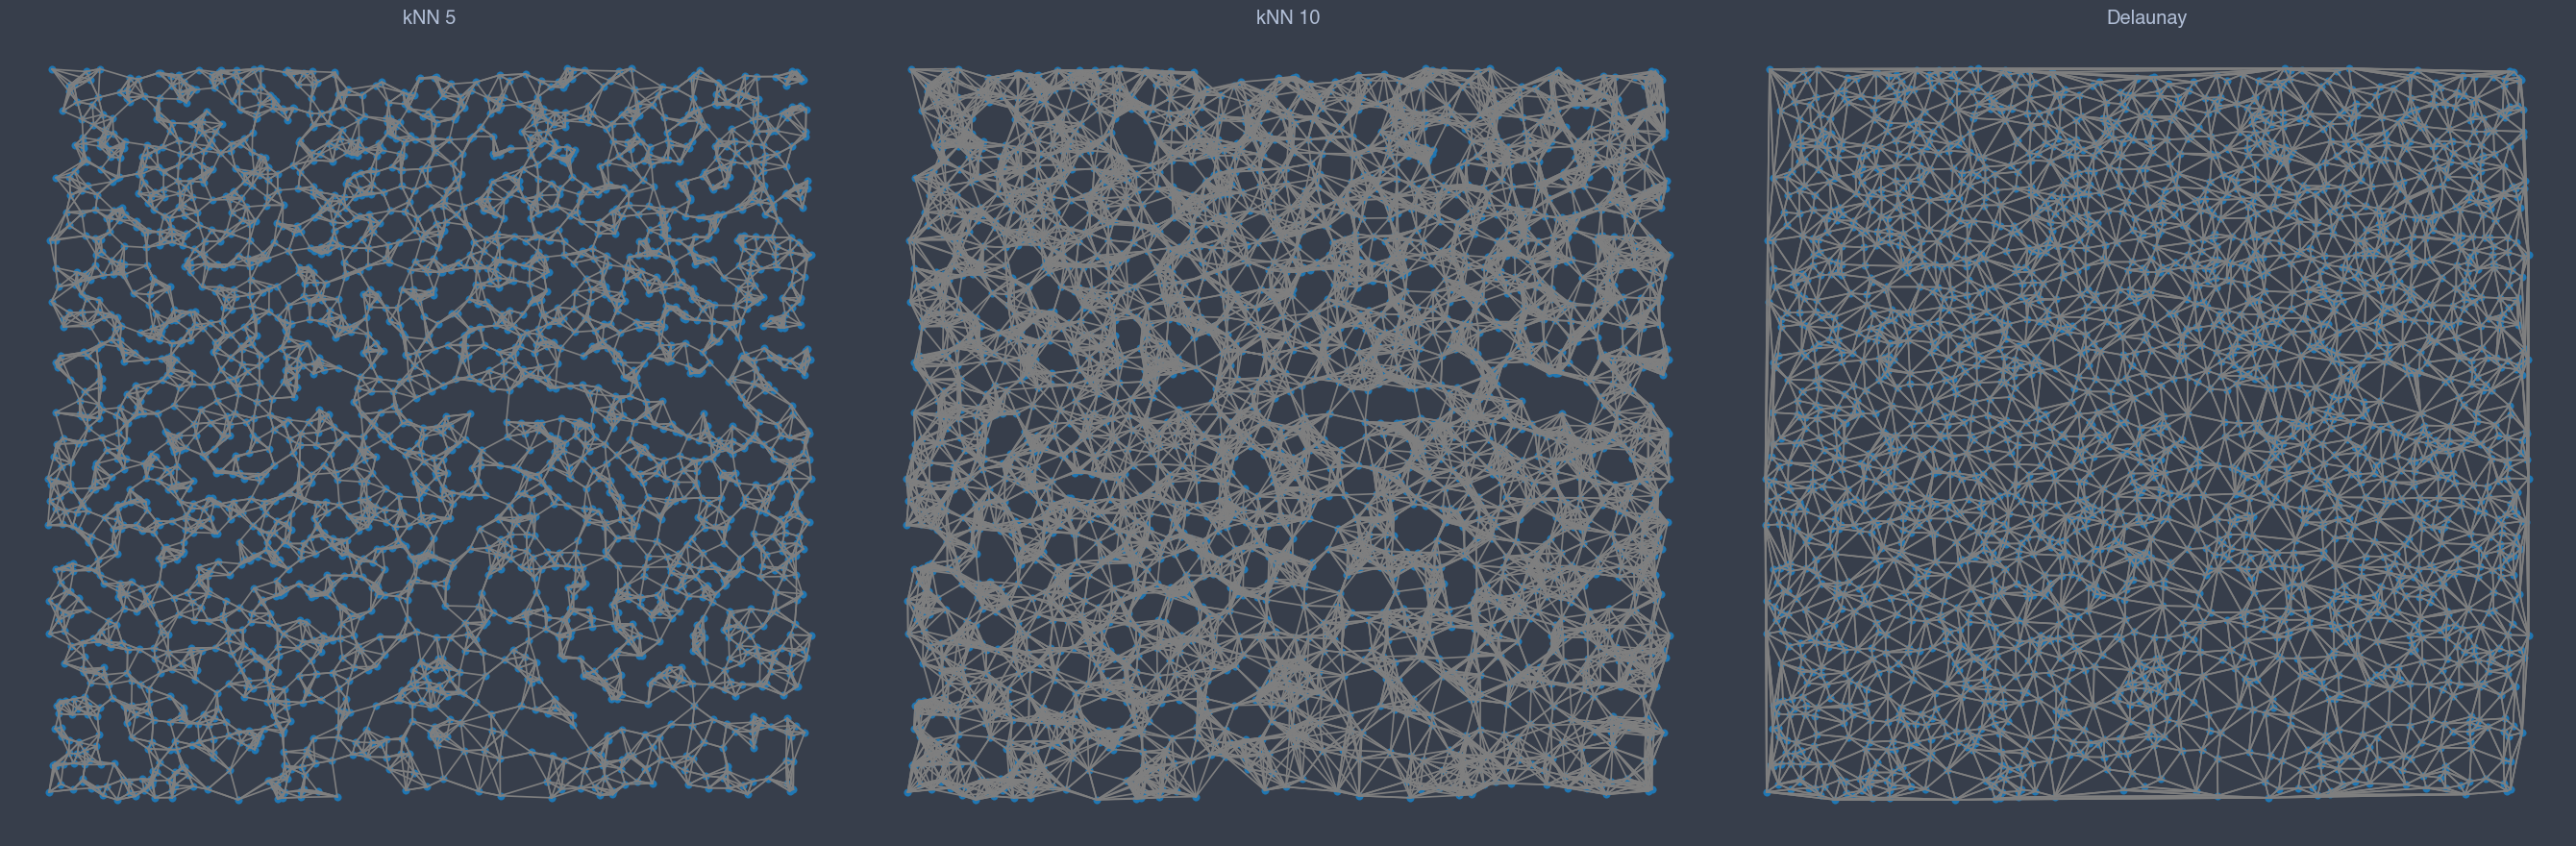

In [7]:
fig, axes = plt.subplots(figsize=(27, 9), ncols=3)

for ax, title, key in zip(axes, ["kNN 5", "kNN 10", "Delaunay"], ["spatial", "knn10", "delaunay"]):
    plot_neighbor_graph(merfish_subset, f"{key}_connectivities", ax=ax)
    ax.set_title(title)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.close(fig)

## Ripley's Statistics

Ripley's statistics calculate the probability of two points being closer than a certain threshold in a neighbor graph. They therefore indicate whether the distribution of points is random, dispersed or clustered for a *given scale* $t$.

### Ripley's L/K

Ripley's K is defined as
$$ K(t) = \lambda^{-1} \sum_{i \neq j} \frac{I(d(i,j) < t)}{n} $$

where $d(\cdot,\cdot)$ is a distance metric and $I(\cdot)$ is a Kronecker delta-like function outputting 1 if the conditions is true and 0 otherwise.<br>
$\lambda$ is a normalization factor for the density of points, usually computed as the number of points over the area of the region.<br>
In the case of uniformly distributed points, $K(t) \approx \pi t^2$.

$K$ is turned into $L$ via variance-stabilizing transformation

$$ L(t) = \left(\frac{K(t)}{\pi}\right)^{1/2} $$

such that for a uniform distribution $L(t) \approx t$

### Ripley's F/G

$$R(t) = P\left(d(i,j) \leq t\right)$$
Where $R(t) = F(t)$ if $d(\cdot,\cdot)$ is the distance to a random *Poisson Point Process* and $R(t) = G(t)$ if $d(\cdot,\cdot)$ is a metric to other points in the data, typically the euclidean distance.



**Notes on the `squidpy` implementation ([`sq.gr.ripley`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.ripley.html))**

To compute p-values for the statistics, `squidpy` simulates n random Poisson Point Processes (simulating homogeneous distributions) and computes empirical p-values by comparing the Ripley's statistics of that of the simulations. The number of simulations can be set with `n_simulations` and represents a trade-off between runtime and robustness (and maximum precision) of the p-value estimate. 
To get reproducible p-value estimates, always make sure to pass a `seed` (Note that the seed is also used when `mode = "F"`).

As the computation depends on a kNN graph, the `n_neigbhors` has a similar effect as to what we have already seen above.

**Task**: compute Ripley's F, G and L and plot for 

**Questions**:<br>
How do you interpret the resulting plots? (hint: what do the different axes indicate?)<br>
Where do you think the difference between F/G and L come from?

In [ ]:
# compute ripley's F
ripley_f = sq.gr.ripley(merfish, "Cell_class", mode="F", copy=False)
# compute ripley's G
ripley_g = sq.gr.ripley(merfish, "Cell_class", mode="G", copy=False)
# compute ripley's L
ripley_l = sq.gr.ripley(merfish, "Cell_class", mode="L", copy=False)

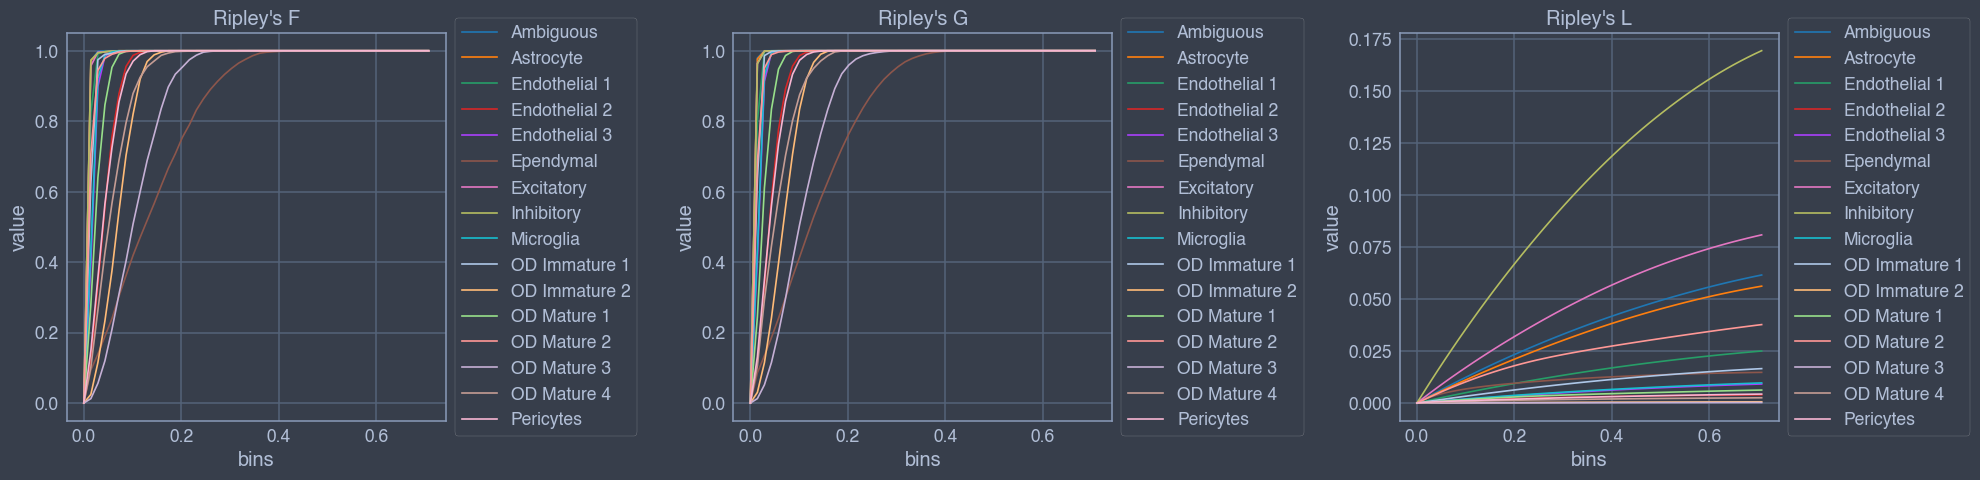

In [9]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=3)

for i, (ax, mode) in enumerate(zip(axes, ["F", "G", "L"])):
    sq.pl.ripley(merfish, cluster_key="Cell_class", mode=mode, ax=ax)
    ax.set_title(f"Ripley's {mode}")

plt.tight_layout()
plt.show()
plt.close(fig)

## Spatial Autocorrelation

Spatial autocorrelation metrics implemented in `squidpy` are Moran's I and Geary's C. We focus on Moran's I.

**Moran's I**<br>
$I = \frac{N}{W} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^{n}(x_i - \bar{x})^2}$


With
* $N$ = number of spatial units, i.e. cells
* $x_i$ = value of variable at location $i$, i.e. the position of a cell
* $\bar{x}$ = mean of variable $x$, i.e. the centroid of a cell population
* $w_{ij}$ = spatial weight between locations $i$ and $j$, i.e. the edge weight in the spatial graph
* $W = \sum_{i=1}^{N}\sum_{j=1}^{N}w_{ij}$ i.e. the sum of all weights

Moran's I ranges from -1 to +1 (positive values indicate positive spatial autocorrelation) (Geary's C ranges from 0 to 2 where values less than 1 indicate positive spatial autocorrelation).<br>
Both statistics are sums of local indicators of spatial association statistics.<br>
The relation of Moran's I and Geary's C is inverse, although they are not inversely equal. 


**Notes on the `squidpy` implementation ([`sq.gr.spatial_autocorr`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.spatial_autocorr.html))**

Unsurprisingly (at this point), the implementation depends on a neighbor graph. In this case, it has to pre-computed and the respective key needs to be passed via `connectivity_key` (e.g. "spatial_connectivities" for the default "spatial" key; this is also the function parameter default).

**Task**: Compute Moran's I once with a 5-NN graph and once with Delaunay triangulation. ad plot the resulting p-value distributions.

**Questions**:<br>
What are the main differences to Ripley's statistics (and why)?<br>
What type of p-values are you plotting? (hint: check the documentation)

In [10]:
sq.gr.spatial_neighbors(merfish, delaunay=False, n_neighs=5)
sq.gr.spatial_neighbors(merfish, delaunay=True, key_added="delaunay")

mi_knn = sq.gr.spatial_autocorr(merfish, copy=True)
mi_delaunay = sq.gr.spatial_autocorr(merfish, connectivity_key="delaunay_connectivities", copy=True)

/opt/miniconda3/lib/python3.12/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 1 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()
/opt/miniconda3/lib/python3.12/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 1 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()


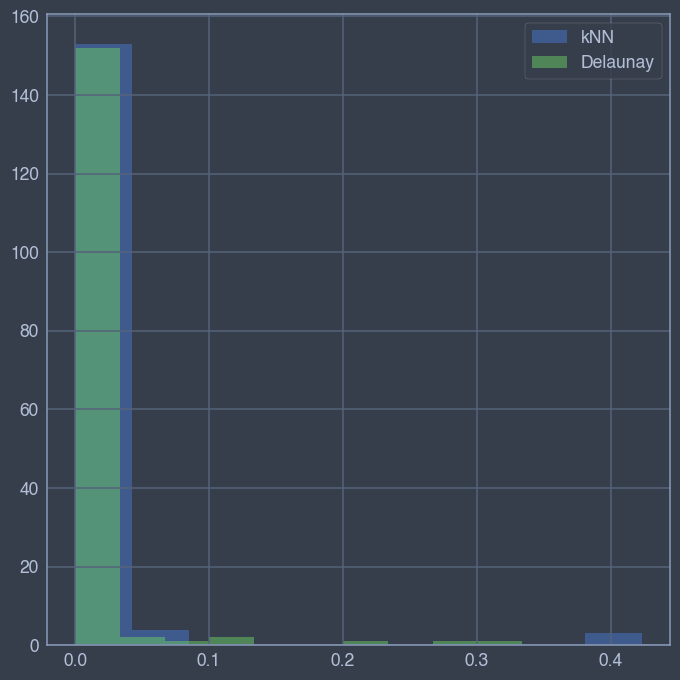

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(mi_knn["pval_norm"], label="kNN", alpha=.5)
ax.hist(mi_delaunay["pval_norm"], label="Delaunay", alpha=.5)
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig)

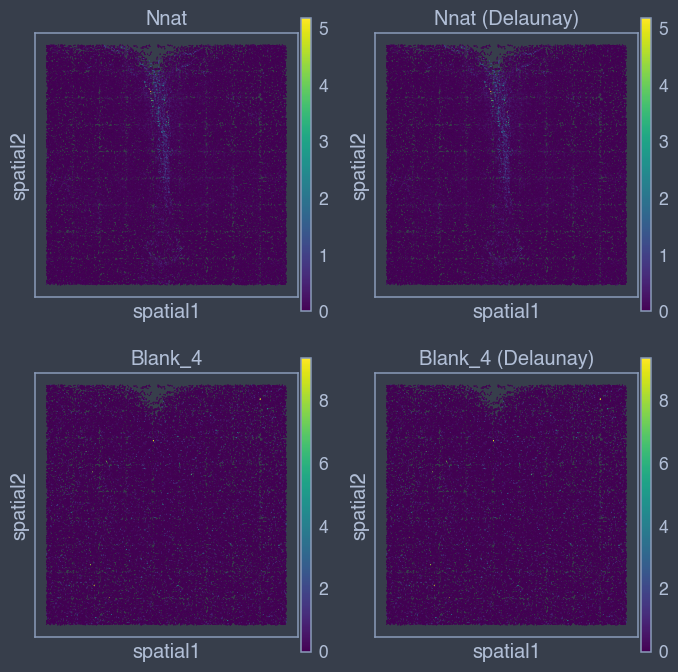

In [34]:
# TODO: choose other genes to be plotted
genes = mi_knn.index[[0, -2]]

fig, axes = plt.subplots(figsize=(7, 7), ncols=2, nrows=2)
for i, gene in enumerate(genes):
    for j, (df, met) in enumerate(zip([mi_knn, mi_delaunay], ["kNN", "Delaunay"])):
        # shape=None is necessary because merfish data does not have a pre-defined
        # shape like spot-based spatial techniques
        sq.pl.spatial_scatter(merfish, ax=axes[i, j], color=gene, shape=None, title=f"{gene} ({met})")
    axes[i, 0].set_title(gene)

plt.tight_layout()
plt.show()
plt.close(fig)

# spatial variance vs. total variance

## Co-Occurrence

Spatial co-occurrence is defined as $\frac{p(c_{t}|c_{c})}{p(c_{t})}$ i.e. the probability of observing a target cell class given the presence of a condition cell class relative to the unconditioned probability.

**Task**: Compute co-occurences between cell types with [`sq.gr.co_occurrence`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.co_occurrence.html) and plot the results [`sq.pl.co_occurrence`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.co_occurrence.html)

**Questions**:<br>
What is the conceptual main differences to Ripley's statistics and Moran's I? (hint: use case)<br>

  0%|          | 0/1 [00:00<?, ?/s]

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


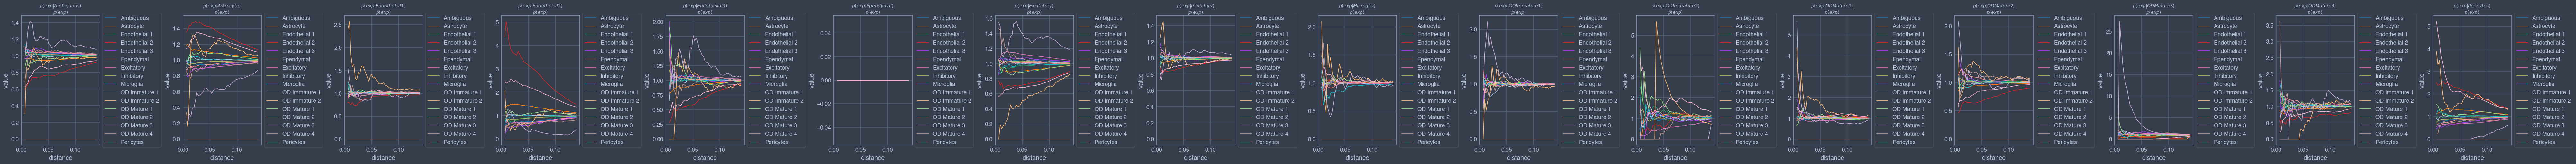

In [14]:
sq.gr.co_occurrence(merfish_subset, cluster_key="Cell_class")
sq.pl.co_occurrence(merfish_subset, cluster_key="Cell_class")

/opt/miniconda3/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


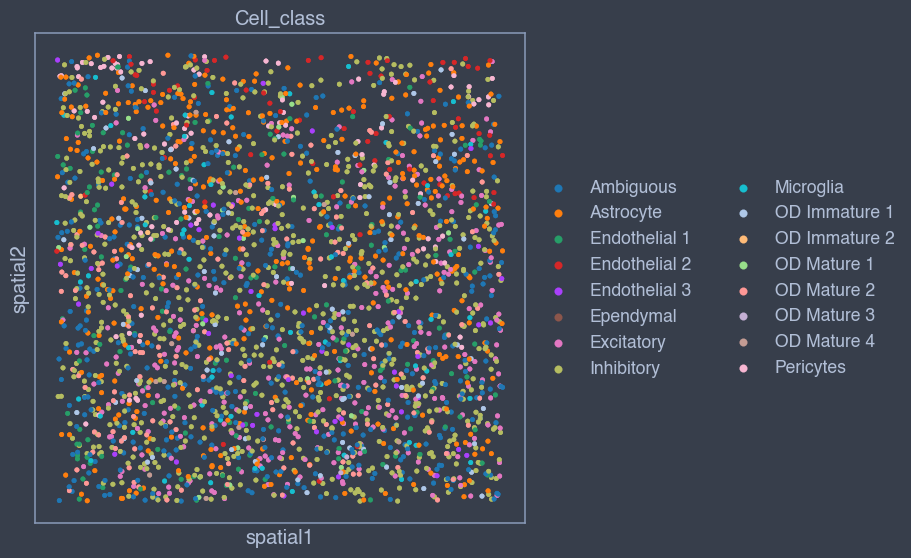

In [15]:
sq.pl.spatial_scatter(merfish_subset, color="Cell_class", shape=None, figsize=(9, 9))

## Neighborhood Enrichment

For two classes $i$ and $j$, e.g. two cell types, the neighborhood enrichment test computes the number of cells from those classes (i.e. cell types) that are neighbors in the spatial neighbor graph. We denote this number by $x_{ij}$

This number is then compared to an estimate of the mean ($\mu_{ij}$) and the standard deviation ($\sigma_{ij}$) of a null distribution by randomizing the cell labels $n$ times.

With these parameters, one can compute a z-score $z_{ij} = \frac{x_{ij} - \mu_{ij}}{\sigma_{ij}}$, which can then be turned into a p-value.

**Notes on the `squidpy` implementation ([`sq.gr.nhood_enrichment`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.nhood_enrichment.html))**

Since the p-value is computed via randomization, make sure to pass a seed. The number of randomizations is controlled via `n_perms` and represents a trade-off between robustness/precision and runtime.

**Task**: Compute and plot the neighborhood enrichment with Delaunay triangulation and a 5-NN graph

**Questions**:
How do you interpret the values shown in the heatmap?<br>
Can you say which color represents "significance"?

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/lib/python3.12/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


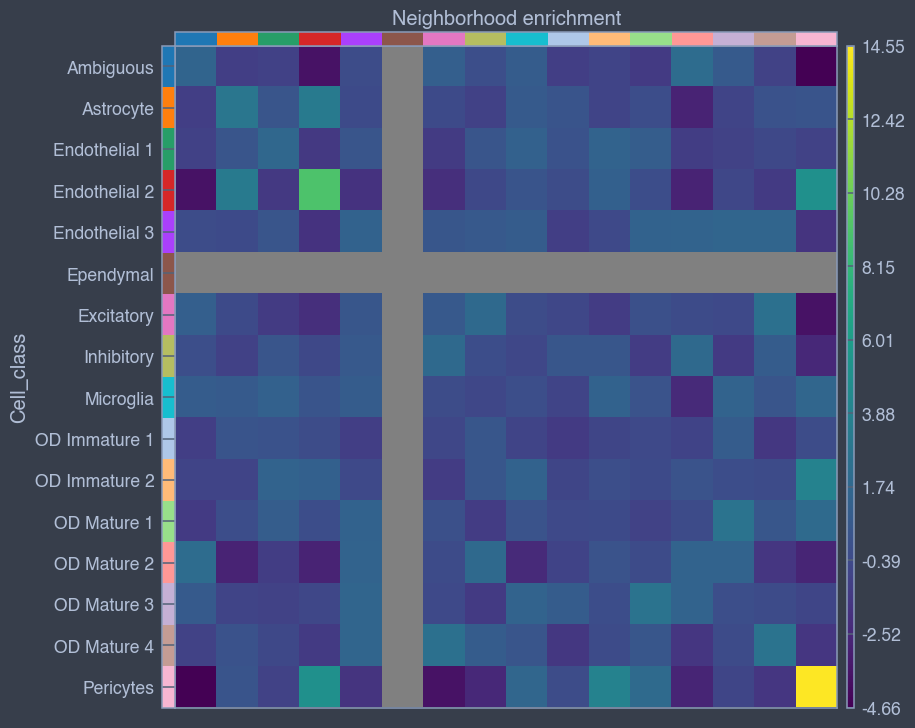

In [16]:
sq.gr.nhood_enrichment(merfish_subset, cluster_key="Cell_class", connectivity_key="delaunay")
sq.pl.nhood_enrichment(merfish_subset, cluster_key="Cell_class", figsize=(7, 7))

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/lib/python3.12/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


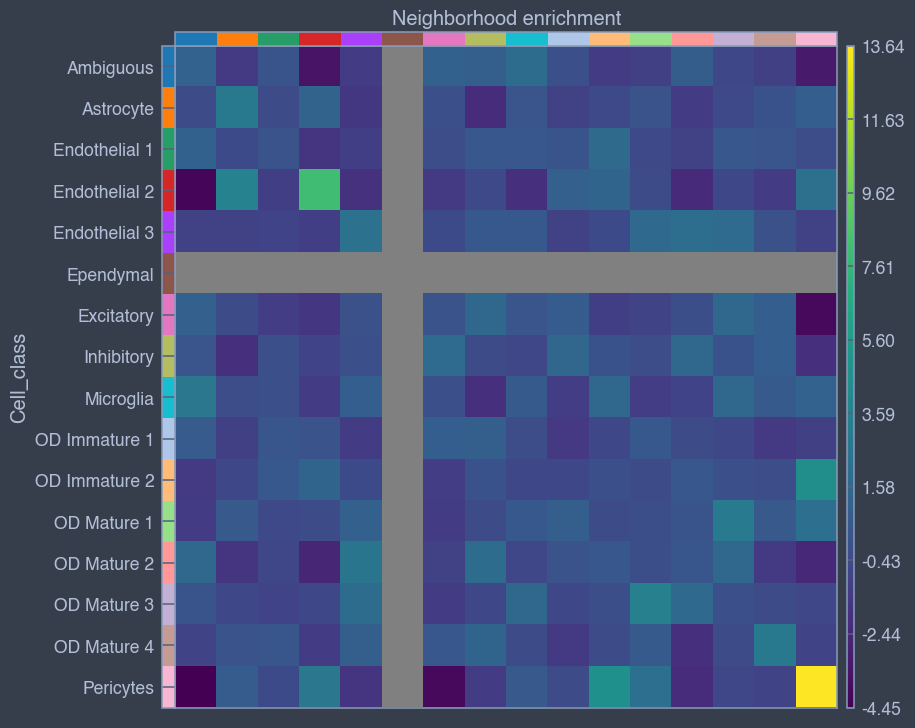

In [17]:
sq.gr.nhood_enrichment(merfish_subset, cluster_key="Cell_class", connectivity_key="spatial")
sq.pl.nhood_enrichment(merfish_subset, cluster_key="Cell_class", figsize=(7, 7))